<a href="https://colab.research.google.com/github/igorz999/Sentiment-analysis/blob/main/bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, BertModel
#
import torch
import torch.nn as nn
#
import torch
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset #ease batching/shuffleing of data,
    # and for TensorDataset easy to use with Dataloader bc of easy pairing of input features with labels
from sklearn.metrics import accuracy_score, classification_report

In [4]:
!pip install kaggle


In [5]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
import io

reviews = pd.read_csv(io.BytesIO(uploaded['imdb.csv']))  # Adjust the filename if necessary


Saving imdb.csv to imdb.csv


In [7]:
len(reviews)
#mali je broj instanci ako samo scraping radis za kvalitetan model? (za sad 71)

50000

In [8]:
reviews

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [10]:
reviews = reviews.drop_duplicates()

In [11]:
reviews.shape

(49582, 2)

In [ ]:
# Load BERT model and tokenizer

#tokenization is essentially turning the sentences/words into tokens,
#tokens are used by the machine to understand the context and process the input better

#tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
#model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased')

In [12]:
reviews['sentiment'] = reviews['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

<ipython-input-12-15a319623c3f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['sentiment'] = reviews['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)


In [13]:
reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


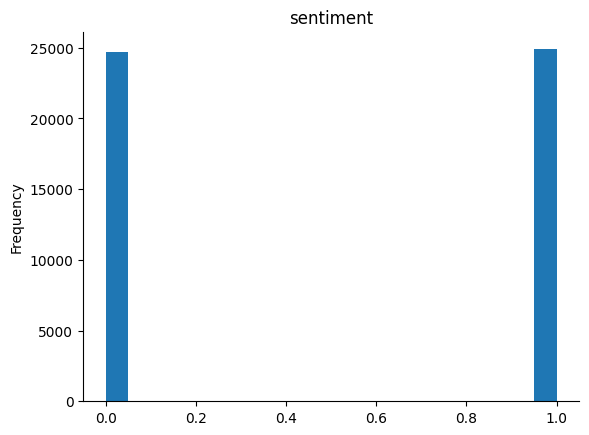

In [14]:
# @title sentiment

from matplotlib import pyplot as plt
reviews['sentiment'].plot(kind='hist', bins=20, title='sentiment')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [15]:
class Tokenize_dataset:
  def __init__(self, text, targets, tokenizer, max_len):
    self.text = text.reset_index(drop=True)  # Ensure continuous integer index
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.targets = targets.reset_index(drop=True)  # Ensure continuous integer index

  def __len__(self):
    return len(self.targets)

  def __getitem__(self, item):
    text = str(self.text[item])
    targets = self.targets[item]
    inputs = self.tokenizer.encode_plus(
        str(text),
        add_special_tokens = True,
        max_length = self.max_len,
        padding='max_length',  # Replace deprecated parameter pad_to_max_length
        truncation=True  # Handle text longer than max_length
    )

    ids = inputs["input_ids"]
    mask = inputs["attention_mask"]
    token_type_ids = inputs.get("token_type_ids", [0] * len(ids))  # Use default if not present

    return {
        "ids": torch.tensor(ids, dtype=torch.long),
        "mask": torch.tensor(mask, dtype=torch.long),
        "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
        "targets": torch.tensor(targets, dtype=torch.long)
    }

In [16]:
train_maxlen = 140
batch_size = 16
epochs = 5
bert_model = 'bert-base-uncased'
learning_rate = 3e-5

In [17]:
class CompleteModel(nn.Module):
    def __init__(self, bert):
        super(CompleteModel, self).__init__()
        self.bert = BertModel.from_pretrained(bert)
        self.drop = nn.Dropout(p=0.25)
        self.out = nn.Linear(self.bert.config.hidden_size, 2)  # Number of output classes = 2 (positive, negative)

    def forward(self, ids, mask, token_type_ids):
        _, pooled_output = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
        output = self.drop(pooled_output)
        return self.out(output)

In [20]:
X = reviews['review']
y = reviews['sentiment']

y.shape

(49582,)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [23]:
tokenizer = AutoTokenizer.from_pretrained(bert_model) # dal treba BertTokenizer?

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [24]:
train_dataset = Tokenize_dataset(X_train, y_train, tokenizer, max_len=train_maxlen)
val_dataset = Tokenize_dataset(X_val, y_val, tokenizer, max_len=train_maxlen)
test_dataset = Tokenize_dataset(X_test, y_test, tokenizer, max_len=train_maxlen)

In [25]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [26]:
model = CompleteModel(bert_model)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [27]:
# Set up training components
optimizer = AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Training loop
print("Starting training process")
for epoch in range(epochs):
    model.train()
    print(f"Epoch {epoch+1}/{epochs} - Training")
    i = 0
    for batch in train_loader:
      ids = batch['ids']
      mask = batch['mask']
      token_type_ids = batch['token_type_ids']
      targets = batch['targets']

      optimizer.zero_grad()
      outputs = model(ids, mask, token_type_ids)  # Expecting only one value returned
      loss = loss_fn(outputs, targets)
      loss.backward()
      optimizer.step()
      if i % 100 == 0:  # Print every 100 batches
          print(f"Completed {i} batches")
      i += 1

    # Validation loop
    model.eval()
    print("Entering evaluation")
    val_loss = 0
    correct_preds = 0
    with torch.no_grad():
        for batch in val_loader:
          ids = batch['ids']
          mask = batch['mask']
          token_type_ids = batch['token_type_ids']
          targets = batch['targets']

          outputs = model(ids, mask, token_type_ids)
          loss = loss_fn(outputs, targets)
          val_loss += loss.item()
          preds = torch.argmax(outputs, dim=1)
          correct_preds += (preds == targets).sum().item()

    print(f'Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss/len(val_loader)}, Accuracy: {correct_preds/len(val_dataset)}')

Starting training process
Epoch 1/5 - Training
Completed 0 batches
Completed 100 batches
